# Effect of Class Length on Grades
Alexander Bailey, Kayli Leung

# Methodology
We will perform a two-tail, two-sample t-test on the data. Using [Kaggle's UW Madison Grade's Database](https://www.kaggle.com/Madgrades/uw-madison-courses#schedules.csv).

## Question

Is there a significant difference in the percentage of A's given based on the length a class. 

## Hypotheses
We select an alpha value of 0.025.

Null Hypothesis: There is no significant difference in the mean percentage of A's in classes of different lengths.

Alternate Hypothesis: There is a significant difference in the mean percentage of A's classes depending on length, divided into 3 main groups: classes <= 1 hour, 1-2 hrs, and 2-3 hrs.

In [95]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [21]:
conn = psycopg2.connect("host=localhost,dbname=postgres,user=postgres")

cur = conn.cursor()

In [22]:
group_and_as = """
SELECT 
  grade.a_count
, grade.ab_count
, grade.b_count
, grade.bc_count
, grade.c_count
, grade.d_count
, grade.f_count
, sched.start_time
, sched.end_time
, sect.section_type
FROM 
  sections sect
INNER JOIN 
  schedules sched 
ON 
  sched.uuid = sect.schedule_uuid
INNER JOIN 
  grade_distributions grade 
ON 
  sect.number = grade.section_number 
AND 
  sect.course_offering_uuid = grade.course_offering_uuid;
"""

In [30]:
cur.execute(group_and_as)
df = pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]
df['total_count'] = (df['a_count'] + df['ab_count'] + df['b_count'] + df['bc_count'] 
                     + df['c_count'] + df['d_count'] + df['f_count'])
df.head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,end_time,section_type,total_count
0,83,0,0,0,0,0,1,-1,-1,FLD,84
1,0,0,0,0,0,0,0,-1,-1,FLD,0
2,0,0,0,0,0,0,0,-1,-1,FLD,0
3,16,44,33,4,5,0,0,800,850,LEC,102
4,11,1,0,0,0,0,0,800,850,LEC,12


In [31]:
df.sort_values(by='start_time').head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,end_time,section_type,total_count
0,83,0,0,0,0,0,1,-1,-1,FLD,84
117437,0,0,0,0,0,0,0,-1,-1,IND,0
117436,0,0,0,0,0,0,0,-1,-1,IND,0
117435,0,0,0,0,0,0,0,-1,-1,IND,0
117434,0,0,0,0,0,0,0,-1,-1,IND,0


Create column for class length:

In [33]:
df['class_length'] = df['end_time'] - df['start_time']
df.head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,end_time,section_type,total_count,class_length
0,83,0,0,0,0,0,1,-1,-1,FLD,84,0
1,0,0,0,0,0,0,0,-1,-1,FLD,0,0
2,0,0,0,0,0,0,0,-1,-1,FLD,0,0
3,16,44,33,4,5,0,0,800,850,LEC,102,50
4,11,1,0,0,0,0,0,800,850,LEC,12,50


In [34]:
df.loc[df['class_length'] == 0,'section_type'].value_counts()

IND    81726
LEC     4405
FLD     3691
SEM     1345
LAB     1331
DIS       19
Name: section_type, dtype: int64

It appears that all classes with a start and end time of -1 also have a class length of 0, mostly independent studies and other classes lacking a regular schedule. Since these are not useful in our current test, we can drop classes with a length of 0.

In [35]:
df = df[df['class_length'] > 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124882 entries, 3 to 217395
Data columns (total 12 columns):
a_count         124882 non-null int64
ab_count        124882 non-null int64
b_count         124882 non-null int64
bc_count        124882 non-null int64
c_count         124882 non-null int64
d_count         124882 non-null int64
f_count         124882 non-null int64
start_time      124882 non-null int64
end_time        124882 non-null int64
section_type    124882 non-null object
total_count     124882 non-null int64
class_length    124882 non-null int64
dtypes: int64(11), object(1)
memory usage: 12.4+ MB


In [41]:
df.sort_values(by='total_count').head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,end_time,section_type,total_count,class_length
170075,0,0,0,0,0,0,0,800,950,LAB,0,150
140682,0,0,0,0,0,0,0,360,1020,FLD,0,660
140675,0,0,0,0,0,0,0,360,1020,FLD,0,660
140674,0,0,0,0,0,0,0,360,1020,FLD,0,660
140673,0,0,0,0,0,0,0,360,1020,FLD,0,660


There are still a number of classes that have no students. We want to drop these as it is not reflective of our study.

In [42]:
df = df[df['total_count'] != 0]

In [43]:
df['total_count'].value_counts().head()

13    3793
12    3661
15    3594
10    3574
19    3546
Name: total_count, dtype: int64

In [44]:
df.sort_values(by='class_length',ascending=False).head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,end_time,section_type,total_count,class_length
167436,11,0,0,0,0,0,0,30,840,LEC,11,810
167437,11,0,0,0,0,0,0,30,840,LEC,11,810
178890,6,6,1,0,0,0,0,150,920,LEC,13,770
131515,8,6,19,0,0,0,0,360,1080,FLD,33,720
13175,10,6,17,0,0,0,1,360,1080,FLD,34,720


In [59]:
df['class_length'].value_counts()

50     33984
75     29275
120     6796
150     6787
180     5814
115     3422
90      1709
60      1541
195     1339
100     1261
660     1115
240     1068
80       802
245      682
540      487
55       456
160      432
110      432
570      405
165      381
600      288
105      286
210      208
70       168
155      126
135      126
630      108
480      104
220      101
555       97
130       80
145       74
65        74
420       71
170       68
85        67
125       66
       ...  
255       51
465       42
250       40
539       37
30        33
185       30
45        30
95        28
360       27
225       25
690       24
720       22
450       21
215       18
390       18
190       17
175       12
525        8
200        7
72         3
64         3
205        2
810        2
645        2
35         2
25         1
520        1
330        1
40         1
181        1
325        1
5          1
770        1
226        1
189        1
340        1
113        1
Name: class_length, Lengt

In [65]:
df.loc[df['class_length'].between(121,180),'class_length'].value_counts()

150    6787
180    5814
160     432
165     381
135     126
155     126
130      80
145      74
170      68
125      66
140      54
175      12
Name: class_length, dtype: int64

In [67]:
df2 = df.copy()

Calculate the Ratio of As for each class

In [68]:
df2['ratio_of_as'] = df['a_count'] / df['total_count']

In [92]:
df2.drop_duplicates(inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70397 entries, 3 to 217395
Data columns (total 13 columns):
a_count         70397 non-null int64
ab_count        70397 non-null int64
b_count         70397 non-null int64
bc_count        70397 non-null int64
c_count         70397 non-null int64
d_count         70397 non-null int64
f_count         70397 non-null int64
start_time      70397 non-null int64
end_time        70397 non-null int64
section_type    70397 non-null object
total_count     70397 non-null int64
class_length    70397 non-null int64
ratio_of_as     70397 non-null float64
dtypes: float64(1), int64(11), object(1)
memory usage: 7.5+ MB


Here we are dividing classes into 3 categories:<br />
short: 1 hour or less<br />
medium: 1-2 hrs<br />
long: over 2-3 hrs<br /> 

In [93]:
df_short = df2[df2['class_length'].between(1,60)]
df_med = df2[df2['class_length'].between(61,120)]
df_long = df2[df2['class_length'].between(121,180)]
print(len(df_short))
print(len(df_med))
print(len(df_long))

25907
32145
9456


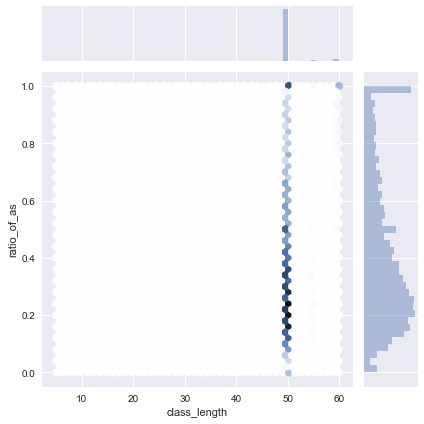

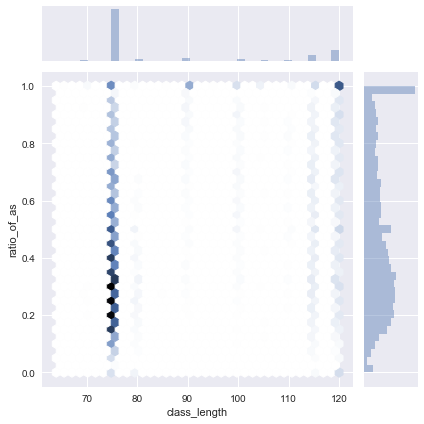

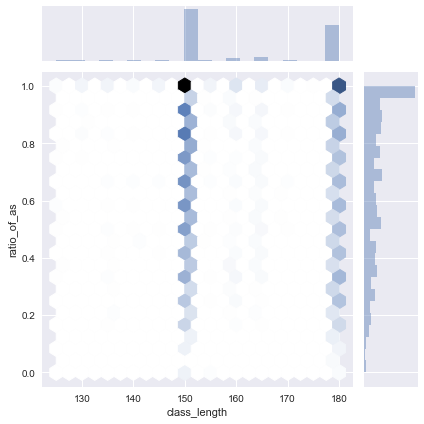

In [94]:
sns.jointplot('class_length', 'ratio_of_as',df_short, kind='hex')
sns.jointplot('class_length', 'ratio_of_as',df_med, kind='hex')
sns.jointplot('class_length', 'ratio_of_as',df_long, kind='hex')
plt.show()

# ANOVA Testing

Because we have several categories of length, we will use anova testing

In [100]:
df3 = df2.copy()
df3['short'] = df2['class_length'].between(1,60).apply(lambda x : int(x))
df3['med'] = df2['class_length'].between(61,120).apply(lambda x : int(x))
df3['long'] = df2['class_length'].between(121,180).apply(lambda x : int(x))
df3.head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,start_time,end_time,section_type,total_count,class_length,ratio_of_as,short,med,long
3,16,44,33,4,5,0,0,800,850,LEC,102,50,0.156863,1,0,0
4,11,1,0,0,0,0,0,800,850,LEC,12,50,0.916667,1,0,0
5,8,4,1,0,0,0,0,660,710,LEC,13,50,0.615385,1,0,0
6,7,3,0,0,0,0,0,660,710,LEC,10,50,0.700000,1,0,0
7,12,0,0,0,0,1,0,725,775,LEC,13,50,0.923077,1,0,0


In [102]:
formula = "ratio_of_as ~ C(short) + C(med) + C(long)"
lm = ols(formula,df3).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

               sum_sq       df           F         PR(>F)
C(short)    23.399946      1.0  319.214429   3.088092e-71
C(med)       2.012132      1.0   27.448854   1.617676e-07
C(long)     45.078331      1.0  614.943890  3.591098e-135
Residual  5160.143899  70393.0         NaN            NaN


This ANOVA test demonstrates that class length, expsecially longer classes, may be influential. This test does not tell us how it impacts the percentage of A's yet, so we will now perform t-tests on the unique pairings.

# T-Tests: Determining Sample Size

Running t-tests on all pairs for further analysis:

In [105]:
moe = 0.1
z = 1.96 # z value for alpha 0.05
short_var = np.var(df_short['ratio_of_as'])
short_n = len(df_short['ratio_of_as'])
med_var = np.var(df_med['ratio_of_as'])
med_n = len(df_med['ratio_of_as'])
long_var = np.var(df_long['ratio_of_as'])
long_n = len(df_long['ratio_of_as'])


In [117]:
num = (short_n - 1) * short_var + (med_n - 1) * med_var + (long_n - 1) * long_var
den = short_n + med_n + long_n - 3
pooled_std = np.sqrt(num/den)

n = 2 * (z * pooled_std / moe)**2
n

55.51256087344818

We will use samples from short, med, and long of size 56.

In [119]:
np.random.seed(15)

short = df_short['ratio_of_as']
med = df_med['ratio_of_as']
long = df_long['ratio_of_as']

short_sample = np.random.choice(short, size=56)
med_sample = np.random.choice(med, size=56)
long_sample = np.random.choice(long, size=56)

In [120]:
print("Short vs Medium classes: " + str(stats.ttest_ind(short_sample, med_sample)))
print("Short vs Long classes: " + str(stats.ttest_ind(short_sample, long_sample)))
print("Medium vs Long classes: " + str(stats.ttest_ind(med_sample, long_sample)))

Short vs Medium classes: Ttest_indResult(statistic=-1.6411050198370414, pvalue=0.10363191821086647)
Short vs Long classes: Ttest_indResult(statistic=-7.553393345990277, pvalue=1.336175217336949e-11)
Medium vs Long classes: Ttest_indResult(statistic=-5.607918624030588, pvalue=1.540801115532373e-07)


When we compare these P-values to our alpha of 0.025 (0.05/2 for a two-tailed test) we can see there is a significant difference in the percentage of A's in classes longer than 2 hours when compared to other class lengths. This may also be influenced by longer classes meeting less days per week, so further research may be required. 